# 📘 Data Science Tutorial: Cleaning and Visualizing OHLC Finance Data

We will be using Open, High, Low, Close (OHLC) data in finance to get a good idea of how to run the following disciplines for data analysis.  In particular, finance data is notoriously noisy and needs careful analysis when it comes to cleaning the data, engineering features, visualizing, and running EDA.  We will tackle each of these subsections separately.

# Outline

1. Data Cleaning
2. Feature Engineering
3. Data Visualization
4. Exploratory Data Analysis (EDA)
5. Best Practices



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ta # if you don't have this please install it (technical analysis toolbox)
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("ignore", category=FutureWarning)

## Data Cleaning

In this section, we will first load up the data and figure out methods to handle the following:

* Handling missing values (forward-fill/back-fill or dropping)
* Detecting outliers or anomalies (e.g., price spikes)
* Dealing with duplicate rows or columns
* Time zone normalization and ensuring uniform time intervals
* Ensuring correct data types (e.g., datetime, float)


We first load up the data.  Note that sometimes your data may be in another format than a csv.  If this is the case, there exist other methods to still manipulate your data as a pandas dataframe by either loading it up in python in a different manner and then converting to a pandas dataframe or perhaps by actually preprocessing the data earlier and instantiating a pandas dataframe object that contains your data.  The latter would be the case if you created a dataset with natural language processing or with numpy arrays for example.

In [2]:
# load up data
df = pd.read_csv('OHLC_corrupted.csv') # index_col lists which columns are the indices
df.head() # inspect data 

,ticker,Timestamp,Close,Open,High,Low,Volume,trade_count
0,MSFT,2020-01-14 09:31:00,163.3300,163.37,163.44,163.260,160876.0,1464.0
1,MSFT,2020-01-14 09:32:00,163.2200,NaN,163.35,163.115,139428.0,1462.0
2,MSFT,2020-01-14 09:33:00,163.4299,163.23,163.46,163.230,147348.0,1423.0
3,MSFT,2020-01-14 09:34:00,163.4100,163.44,163.44,163.340,76360.0,802.0
4,MSFT,2020-01-14 09:35:00,163.1900,163.40,163.44,163.170,99304.0,1093.0


### Initial Info About DataFrame

Check for missing values, data types, and overall structure.

In [3]:
df.info() # quick information about the dataframe, its data, and the amount of memory used in it
display(df.isnull().sum()) # tells you how many null items you have 
df.describe() # quick statistics of the dataframe for columns with a set data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1977840 entries, 0 to 1977839
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ticker       object 
 1   Timestamp    object 
 2   Close        float64
 3   Open         float64
 4   High         float64
 5   Low          float64
 6   Volume       float64
 7   trade_count  float64
dtypes: float64(6), object(2)
memory usage: 120.7+ MB


ticker             0
Timestamp          0
Close          19778
Open           19778
High           19778
Low            19778
Volume         19778
trade_count    19778
dtype: int64

,Close,Open,High,Low,Volume,trade_count
count,1.958062e+06,1.958062e+06,1.958062e+06,1.958062e+06,1.958062e+06,1.958062e+06
mean,3.085994e+02,3.086116e+02,3.088735e+02,3.083565e+02,1.021053e+05,1.206583e+03
std,2.750319e+02,2.750464e+02,2.753482e+02,2.747566e+02,3.751603e+05,1.812236e+03
min,1.828000e+01,1.827000e+01,1.872000e+01,1.826000e+01,1.000000e+02,1.000000e+00
25%,9.889065e+01,9.912000e+01,7.529000e+01,9.838250e+01,9.693000e+03,1.760000e+02
50%,2.428300e+02,2.428400e+02,2.430000e+02,2.426600e+02,3.848500e+04,6.730000e+02
75%,4.191549e+02,4.191500e+02,4.193900e+02,4.189350e+02,1.009170e+05,1.482000e+03
max,2.318015e+03,2.318015e+03,2.318490e+03,2.309710e+03,1.396958e+08,1.175110e+05


###  Data Cleaning

When cleaning data, you make many choices that influence the end result for your dataset.  Each choice should be made with care here because it influences your methodology later on.  

Note that if your have duplicated data, that is usually the first thing you must deal with; however, there exist easy methods to fix those as shown below.  

In [4]:
df = df.drop_duplicates() # remove duplicates

Many times, it is important also to create the right datatype for the data used.  For example, in this dataset, the `Timestamp` column is a string or object datatype, but that datatype does not have any useful information about the actual time associated to the string.  We will transform this column's datatype correctly.

In [5]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Timestamp'].dt.date # .time

0          2020-01-14
1          2020-01-14
2          2020-01-14
3          2020-01-14
4          2020-01-14
              ...    
1977835    2025-01-24
1977836    2025-01-24
1977837    2025-01-24
1977838    2025-01-24
1977839    2025-01-24
Name: Timestamp, Length: 1977840, dtype: object

It is useful to sort the dataframe and provide the proper index.  Here, we will generate a multi-index dataset so that there are fast ways to query the data with respect to the ticker we care about as well as the times we care about.

In [6]:
df = df.sort_values(by=["ticker", "Timestamp"]) # sort values based on ticker and timestamp
df = df.set_index(['ticker', 'Timestamp'])

In [7]:
df.reset_index()

,ticker,Timestamp,Close,Open,High,Low,Volume,trade_count
0,MSFT,2020-01-14 09:31:00,163.3300,163.37,163.44,163.260,160876.0,1464.0
1,MSFT,2020-01-14 09:32:00,163.2200,NaN,163.35,163.115,139428.0,1462.0
2,MSFT,2020-01-14 09:33:00,163.4299,163.23,163.46,163.230,147348.0,1423.0
3,MSFT,2020-01-14 09:34:00,163.4100,163.44,163.44,163.340,76360.0,802.0
4,MSFT,2020-01-14 09:35:00,163.1900,163.40,163.44,163.170,99304.0,1093.0
...,...,...,...,...,...,...,...,...
1977835,ZION,2025-01-24 15:56:00,58.6250,58.59,58.63,58.590,10532.0,205.0
1977836,ZION,2025-01-24 15:57:00,58.6400,58.62,58.65,58.620,10194.0,201.0
1977837,ZION,2025-01-24 15:58:00,58.5850,58.63,58.64,58.580,16669.0,468.0
1977838,ZION,2025-01-24 15:59:00,58.6100,58.59,58.66,58.590,32846.0,770.0


In [8]:
df.loc["MSFT", "2024-01-02"] # select a specific ticker and date range

,Close,Open,High,Low,Volume,trade_count
Timestamp,,,,,,
2024-01-02 09:30:00,375.49,373.6900,375.525,373.6700,659395.0,9527.0
2024-01-02 09:31:00,374.59,375.4402,375.900,374.5900,151561.0,3260.0
2024-01-02 09:32:00,373.66,374.5900,374.720,373.5900,112916.0,2507.0
2024-01-02 09:33:00,372.52,373.6900,373.690,372.4200,168612.0,NaN
2024-01-02 09:34:00,371.40,372.4660,372.560,371.4000,157801.0,3307.0
...,...,...,...,...,...,...
2024-01-02 15:56:00,370.85,370.5200,370.870,370.5200,122860.0,2226.0
2024-01-02 15:57:00,NaN,370.8300,371.030,370.7900,143242.0,2669.0
2024-01-02 15:58:00,371.18,371.0000,371.200,370.9393,238394.0,4061.0


For missing data, one usually decides between filling in the missing data somehow or keeping it out.  If you want to estimate the missing values, many choose to fill it in with a forward-fill, backward-fill, or estimate it as an average of between the missing data.  There are many ways to do this step if you choose to fill in the data, but this requires careful decision-making as it fundamentally changes the data, and you don't want to skew the data.

In [9]:
# Forward fill short missing gaps
df.fillna(method='ffill', limit=2)
# df.ffill(limit=2) # bfill(limit=2)
# df.bfill(limit=2)

Close    Open    High      Low    Volume  \
ticker Timestamp                                                          
MSFT   2020-01-14 09:31:00  163.3300  163.37  163.44  163.260  160876.0   
       2020-01-14 09:32:00  163.2200  163.37  163.35  163.115  139428.0   
       2020-01-14 09:33:00  163.4299  163.23  163.46  163.230  147348.0   
       2020-01-14 09:34:00  163.4100  163.44  163.44  163.340   76360.0   
       2020-01-14 09:35:00  163.1900  163.40  163.44  163.170   99304.0   
...                              ...     ...     ...      ...       ...   
ZION   2025-01-24 15:56:00   58.6250   58.59   58.63   58.590   10532.0   
       2025-01-24 15:57:00   58.6400   58.62   58.65   58.620   10194.0   
       2025-01-24 15:58:00   58.5850   58.63   58.64   58.580   16669.0   
       2025-01-24 15:59:00   58.6100   58.59   58.66   58.590   32846.0   
       2025-01-24 16:00:00   58.6400   58.64   58.64   58.640  234106.0   

                            trade_count  
ticker Timestamp                         
MSFT   2020-01-14 09:31:00       1464.0  
       2020-01-14 09:32:00       1462.0  
       2020-01-14 09:33:00       1423.0  
       2020-01-14 09:34:00        802.0  
       2020-01-14 09:35:00       1093.0  
...                                 ...  
ZION   2025-01-24 15:56:00        205.0  
       2025-01-24 15:57:00        201.0  
       2025-01-24 15:58:00        468.0  
       2025-01-24 15:59:00        770.0  
       2025-01-24 16:00:00         33.0  

[1977840 rows x 6 columns]

In [10]:
# IPCA


## Feature Engineering

Many times, the features available in the dataset outright are not enough to detect trends easily.  We must use some method to produce better/more informative features for the dataset.  The usual methodology to create richer features is either by using machine learning (black-box) or by using feature engineering (user-defined).  We will go over feature engineering because machine learning is beyond the scope of this class.  In particular, we will create a few features from scratch and then use a library to generate returns in general.  Additionally, we can generate categorical flags (day of week, end of month, etc) and lagged features or rolling statistics.

In [11]:
# start with each features
df["return"] = df.groupby("ticker")["Close"].pct_change() # groupby does this for each individual ticker
# rolling(20) allows you to calculate something on rolling basis of 20 rows
df["rolling_vol"] = df.groupby("ticker")["return"].rolling(20, min_periods=0).std().reset_index(level=0, drop=True)
df

Close    Open    High      Low    Volume  \
ticker Timestamp                                                          
MSFT   2020-01-14 09:31:00  163.3300  163.37  163.44  163.260  160876.0   
       2020-01-14 09:32:00  163.2200     NaN  163.35  163.115  139428.0   
       2020-01-14 09:33:00  163.4299  163.23  163.46  163.230  147348.0   
       2020-01-14 09:34:00  163.4100  163.44  163.44  163.340   76360.0   
       2020-01-14 09:35:00  163.1900  163.40  163.44  163.170   99304.0   
...                              ...     ...     ...      ...       ...   
ZION   2025-01-24 15:56:00   58.6250   58.59   58.63   58.590   10532.0   
       2025-01-24 15:57:00   58.6400   58.62   58.65   58.620   10194.0   
       2025-01-24 15:58:00   58.5850   58.63   58.64   58.580   16669.0   
       2025-01-24 15:59:00   58.6100   58.59   58.66   58.590   32846.0   
       2025-01-24 16:00:00   58.6400   58.64   58.64   58.640  234106.0   

                            trade_count    return  rolling_vol  
ticker Timestamp                                                
MSFT   2020-01-14 09:31:00       1464.0       NaN          NaN  
       2020-01-14 09:32:00       1462.0 -0.000673          NaN  
       2020-01-14 09:33:00       1423.0  0.001286     0.001386  
       2020-01-14 09:34:00        802.0 -0.000122     0.001010  
       2020-01-14 09:35:00       1093.0 -0.001346     0.001118  
...                                 ...       ...          ...  
ZION   2025-01-24 15:56:00        205.0  0.000597     0.000765  
       2025-01-24 15:57:00        201.0  0.000256     0.000765  
       2025-01-24 15:58:00        468.0 -0.000938     0.000797  
       2025-01-24 15:59:00        770.0  0.000427     0.000800  
       2025-01-24 16:00:00         33.0  0.000512     0.000781  

[1977840 rows x 8 columns]

In [12]:
from ta import add_all_ta_features
# create a bunch of technical analysis features for each ticker individually
tickers = df.index.get_level_values('ticker').unique()
df_list = []
for ticker in tickers:
    print('Working on adding features to', ticker)
    ticker_df = df.loc[ticker]
    ticker_df = add_all_ta_features(ticker_df, open='Open', high='High', low='Low', close='Close', volume='Volume')
    ticker_df['ticker'] = ticker
    ticker_df = ticker_df.reset_index().set_index(['ticker', 'Timestamp'])
    df_list.append(ticker_df)
df_ta = pd.concat(df_list, axis=0)
df_ta

Working on adding features to MSFT
Working on adding features to NVDA
Working on adding features to TSLA
Working on adding features to ZION


Close    Open    High      Low    Volume  \
ticker Timestamp                                                          
MSFT   2020-01-14 09:31:00  163.3300  163.37  163.44  163.260  160876.0   
       2020-01-14 09:32:00  163.2200     NaN  163.35  163.115  139428.0   
       2020-01-14 09:33:00  163.4299  163.23  163.46  163.230  147348.0   
       2020-01-14 09:34:00  163.4100  163.44  163.44  163.340   76360.0   
       2020-01-14 09:35:00  163.1900  163.40  163.44  163.170   99304.0   
...                              ...     ...     ...      ...       ...   
ZION   2025-01-24 15:56:00   58.6250   58.59   58.63   58.590   10532.0   
       2025-01-24 15:57:00   58.6400   58.62   58.65   58.620   10194.0   
       2025-01-24 15:58:00   58.5850   58.63   58.64   58.580   16669.0   
       2025-01-24 15:59:00   58.6100   58.59   58.66   58.590   32846.0   
       2025-01-24 16:00:00   58.6400   58.64   58.64   58.640  234106.0   

                            trade_count    return  rolling_vol    volume_adi  \
ticker Timestamp                                                               
MSFT   2020-01-14 09:31:00       1464.0       NaN          NaN -3.575022e+04   
       2020-01-14 09:32:00       1462.0 -0.000673          NaN -5.058299e+04   
       2020-01-14 09:33:00       1423.0  0.001286     0.001386  5.819827e+04   
       2020-01-14 09:34:00        802.0 -0.000122     0.001010  8.874227e+04   
       2020-01-14 09:35:00       1093.0 -0.001346     0.001118  4.149978e+03   
...                                 ...       ...          ...           ...   
ZION   2025-01-24 15:56:00        205.0  0.000597     0.000765 -3.101485e+06   
       2025-01-24 15:57:00        201.0  0.000256     0.000765 -3.098087e+06   
       2025-01-24 15:58:00        468.0 -0.000938     0.000797 -3.111978e+06   
       2025-01-24 15:59:00        770.0  0.000427     0.000800 -3.126055e+06   
       2025-01-24 16:00:00         33.0  0.000512     0.000781 -3.126055e+06   

                             volume_obv  ...  momentum_ppo  \
ticker Timestamp                         ...                 
MSFT   2020-01-14 09:31:00     160876.0  ...           NaN   
       2020-01-14 09:32:00      21448.0  ...           NaN   
       2020-01-14 09:33:00     168796.0  ...           NaN   
       2020-01-14 09:34:00      92436.0  ...           NaN   
       2020-01-14 09:35:00      -6868.0  ...           NaN   
...                                 ...  ...           ...   
ZION   2025-01-24 15:56:00  428227541.0  ...      0.002498   
       2025-01-24 15:57:00  428237735.0  ...      0.010961   
       2025-01-24 15:58:00  428221066.0  ...      0.009978   
       2025-01-24 15:59:00  428253912.0  ...      0.012497   
       2025-01-24 16:00:00  428488018.0  ...      0.018413   

                            momentum_ppo_signal  momentum_ppo_hist  \
ticker Timestamp                                                     
MSFT   2020-01-14 09:31:00                  NaN                NaN   
       2020-01-14 09:32:00                  NaN                NaN   
       2020-01-14 09:33:00                  NaN                NaN   
       2020-01-14 09:34:00                  NaN                NaN   
       2020-01-14 09:35:00                  NaN                NaN   
...                                         ...                ...   
ZION   2025-01-24 15:56:00            -0.007919           0.010417   
       2025-01-24 15:57:00            -0.004143           0.015104   
       2025-01-24 15:58:00            -0.001319           0.011297   
       2025-01-24 15:59:00             0.001444           0.011053   
       2025-01-24 16:00:00             0.004838           0.013575   

                            momentum_pvo  momentum_pvo_signal  \
ticker Timestamp                                                
MSFT   2020-01-14 09:31:00           NaN                  NaN   
       2020-01-14 09:32:00           NaN                  NaN   
       2020-01-14 09:33:00          

In [13]:
df_ta.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1977840 entries, ('MSFT', Timestamp('2020-01-14 09:31:00')) to ('ZION', Timestamp('2025-01-24 16:00:00'))
Data columns (total 94 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Close                      float64
 1   Open                       float64
 2   High                       float64
 3   Low                        float64
 4   Volume                     float64
 5   trade_count                float64
 6   return                     float64
 7   rolling_vol                float64
 8   volume_adi                 float64
 9   volume_obv                 float64
 10  volume_cmf                 float64
 11  volume_fi                  float64
 12  volume_em                  float64
 13  volume_sma_em              float64
 14  volume_vpt                 float64
 15  volume_vwap                float64
 16  volume_mfi                 float64
 17  volume_nvi                 float64
 18  volati

In [30]:
df_ta.columns

Index(['Close', 'Open', 'High', 'Low', 'Volume', 'trade_count', 'return',
       'rolling_vol', 'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi',
       'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'tr

## Data Visualization

To visualize the data properly, we will use matplotlib and create a plotting method with enough functionality to plot everything that we would like to.  Data visualization should be informative and that requires the data itself to be clean and well-managed beforehand.  In particular, we will plot the following.

* Price and features over time line plots
* Heatmaps for correlations between stocks
* Distribution plots (log-returns, volumes)


In [26]:
# plotting method with indexing methodology

def plot_columns(df=None, cols=['Close', 'Open'], index=30, delStep=None):
    """
    Plots the specified columns for a given index from df.

    Parameters:
    index: int, optional
        The index to use for selecting the data to plot (default is 30).
    cols: list, optional
        The columns to plot (default is ['Close', 'target']).
    df: dataframe for which to plot information
    """

    # check if there are multiple levels for df
    plt_data = df[cols]
    
    if delStep is not None:
        plt_data = plt_data.iloc[delStep*index: delStep*(index+1)]

    # Create the figure with subplots in a grid based on the number of columns
    num_cols = len(cols)
    fig, axs = plt.subplots(num_cols, 1, figsize=(15, 5 * num_cols), sharex=True)

    # Ensure axs is iterable even if there is only one subplot
    if num_cols == 1:
        axs = [axs]

    for i, col in enumerate(cols):
        axs[i].plot(plt_data[col], label=col, alpha=0.6)
        axs[i].legend()
        axs[i].set_title(f'{col} Plot')
        axs[i].set_ylabel(col)

    plt.show()


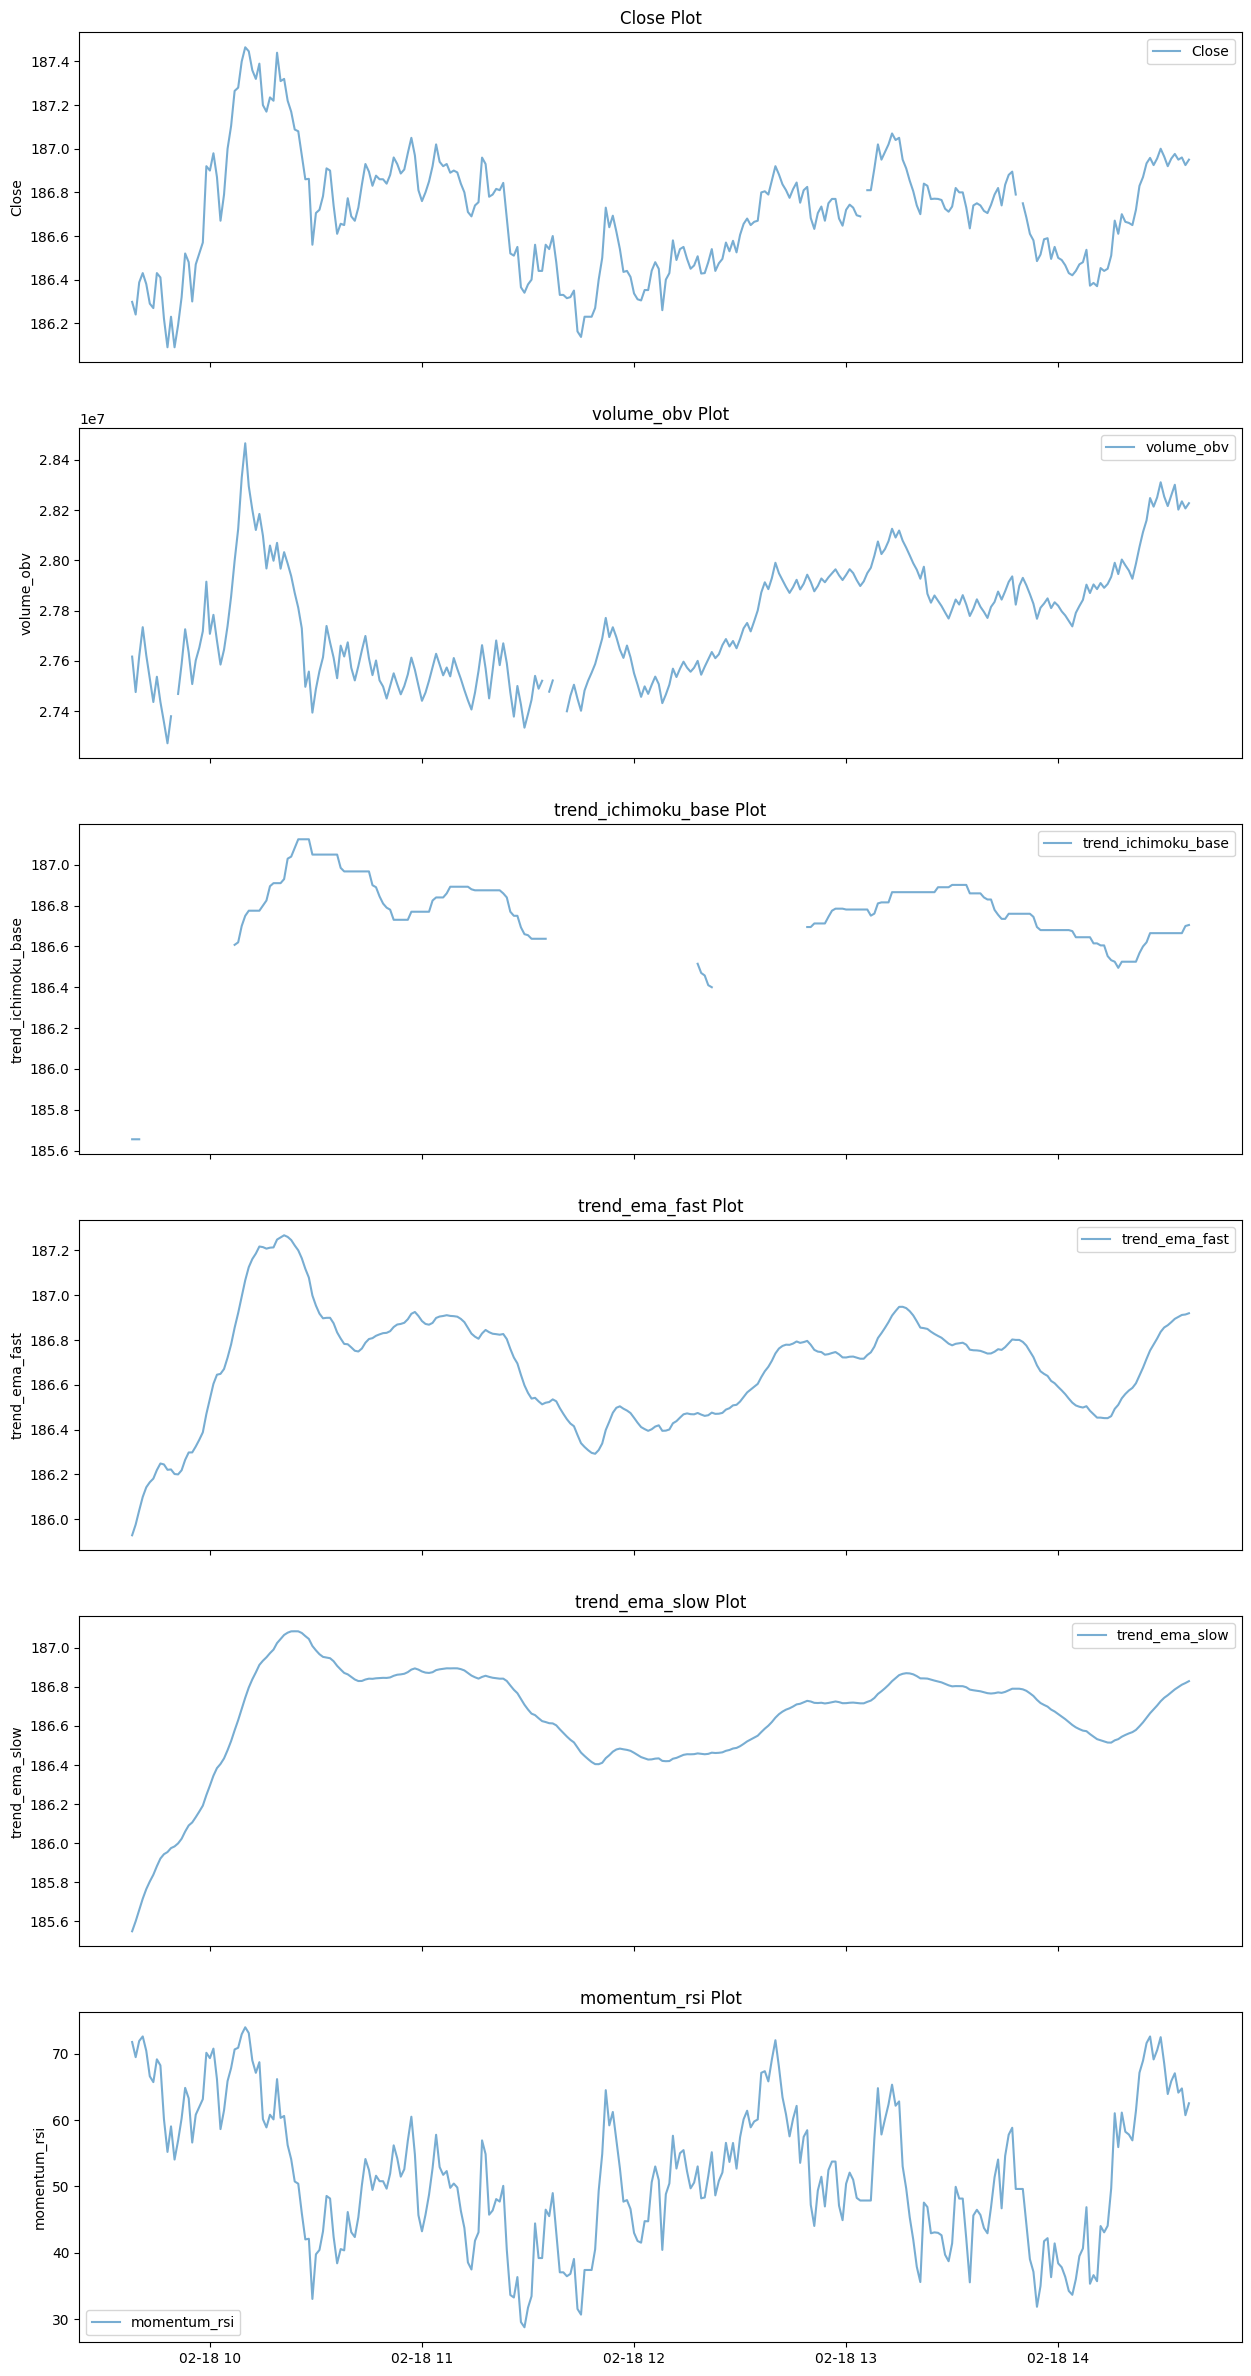

In [32]:
cols = ['Close', 'volume_obv', 'trend_ichimoku_base', 'trend_ema_fast', 'trend_ema_slow', 'momentum_rsi']
plot_columns(df = df_ta.loc['MSFT'], # only plot data for MSFT
             cols=cols, 
             index=30, 
             delStep=300 # there are 390 minutes in a trading day
)

In [28]:
# generate correlation heatmaps

def plot_ticker_correlation_heatmaps(
    df,
    date,
    columns=['return'],
    correlation_method='pearson',
    figsize=(12, 6),
    annot=False
):
    """
    Plots heatmaps of pairwise correlations between tickers for a specific date.
    
    Parameters:
    - df: pd.DataFrame with multi-index ['ticker', 'Timestamp']
    - date: str or pd.Timestamp (e.g., '2024-01-03')
    - columns: str or list of str; columns to compute correlation for
    - correlation_method: correlation method ('pearson', 'spearman', 'kendall')
    - figsize: tuple; size of each heatmap
    - annot: bool; whether to annotate heatmap cells
    """

    # Ensure datetime format
    df = df.copy()
    df = df.reset_index()
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index(['ticker', 'Timestamp'])

    # Ensure list format for columns
    if isinstance(columns, str):
        columns = [columns]

    # Filter data for selected date
    daily_data = df.loc[pd.IndexSlice[:, date], :]

    num_cols = len(columns)
    fig, axes = plt.subplots(1, num_cols, figsize=(figsize[0]*num_cols, figsize[1]), squeeze=False)
    
    for i, col in enumerate(columns):
        if col not in daily_data.columns:
            print(f"Column '{col}' not found in DataFrame.")
            continue
        
        # Reshape: rows = timestamps, columns = tickers
        pivot_data = daily_data[col].unstack(level=0)

        # Compute correlation
        corr = pivot_data.corr(method=correlation_method)

        # Plot heatmap
        ax = axes[0, i]
        sns.heatmap(corr, ax=ax, cmap='coolwarm', annot=annot, fmt=".2f", center=0)
        ax.set_title(f'{col} Correlation - {date}')
    
    plt.tight_layout()
    plt.show()


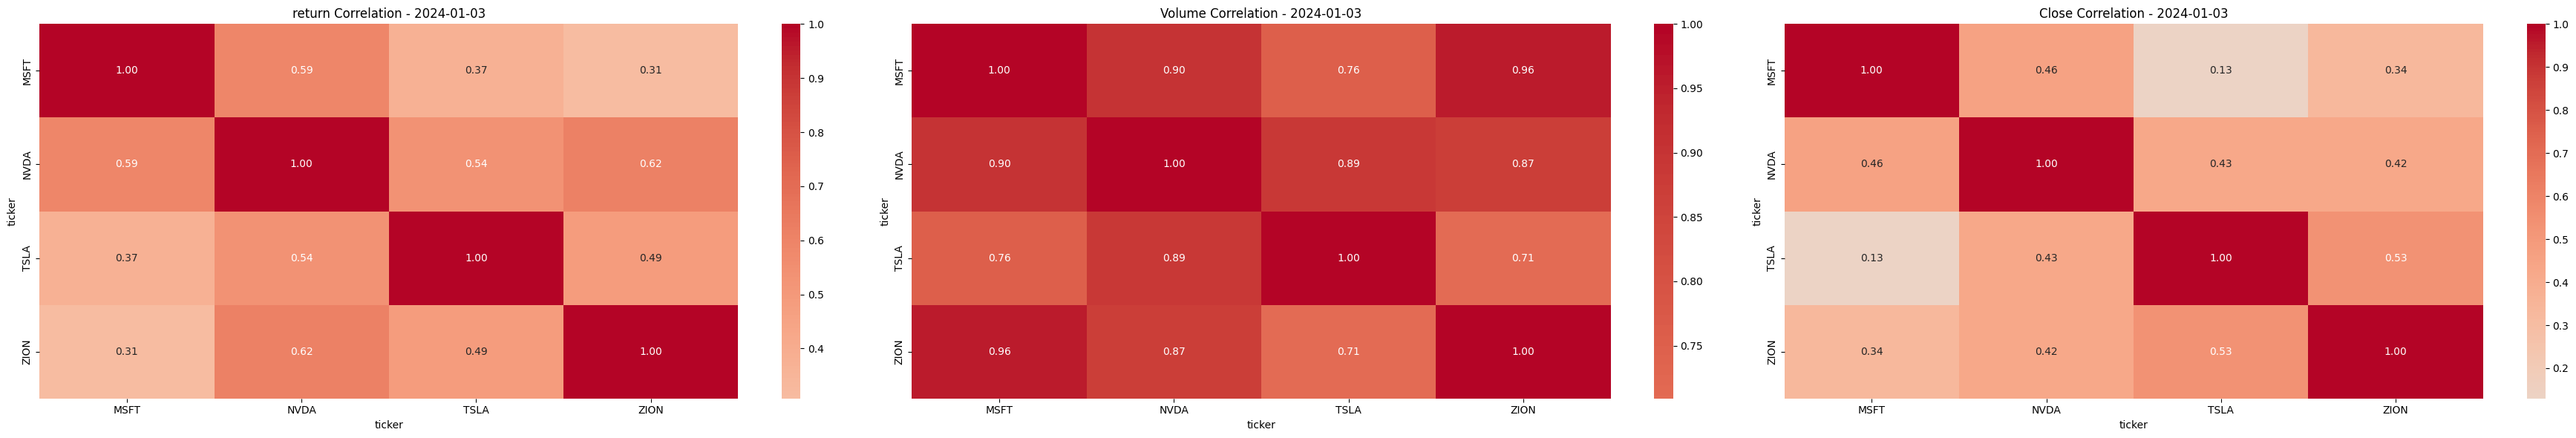

In [29]:
# Multiple columns (each gets its own heatmap)
plot_ticker_correlation_heatmaps(df_ta, date='2024-01-03', columns=['return', 'Volume', 'Close'], annot=True)


In [33]:
# plotting distributions of columns

def plot_column_distribution(df, date, ticker, column='return', bins=50, kde=True, dropna=True):
    """
    Plots the distribution/histogram of a specific column across all tickers
    for a specific date.

    Parameters:
    - df: pd.DataFrame with MultiIndex ['ticker', 'Timestamp']
    - date: str or pd.Timestamp (e.g., '2024-01-03')
    - column: str; the column to plot (e.g., 'return', 'Volume')
    - bins: int; number of histogram bins
    - kde: bool; whether to overlay a kernel density estimate
    - dropna: bool; whether to drop NaN values from the column
    """
    df = df.copy()
    df = df.reset_index()
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index(['ticker', 'Timestamp'])

    # Filter for the date
    try:
        daily_data = df.loc[pd.IndexSlice[ticker, date], column]
    except KeyError:
        print(f"No data found for date: {date}")
        return

    if dropna:
        daily_data = daily_data.dropna()

    # Plot
    plt.figure(figsize=(10, 6))
    sns.histplot(daily_data.values, bins=bins, kde=kde, edgecolor='black')
    plt.title(f"Distribution of '{column}' on {date}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


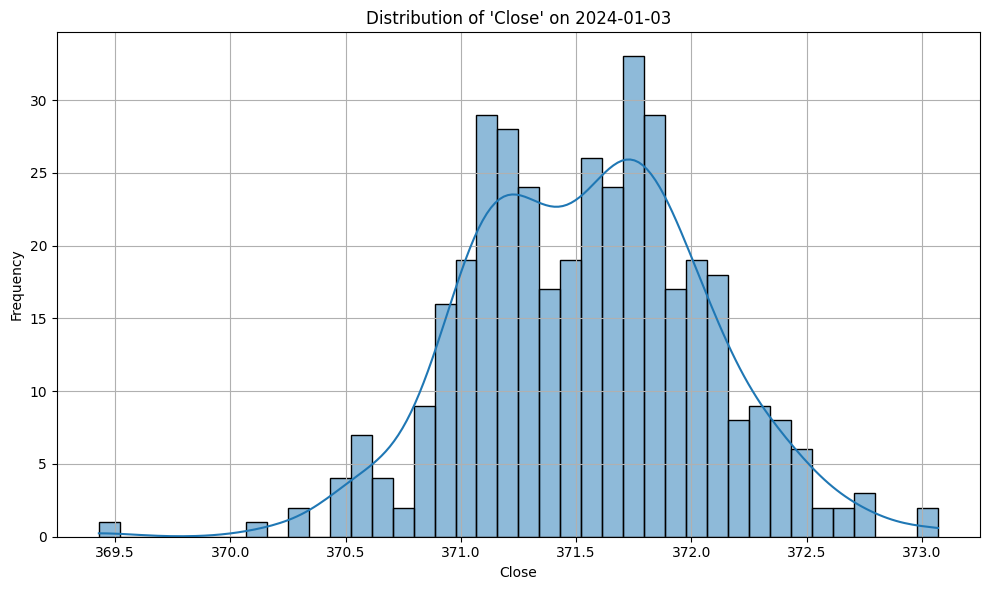

In [37]:
plot_column_distribution(df_ta, date='2024-01-03', ticker='MSFT', column='Close', bins=40, kde=True)


## Exploratory Data Analysis (EDA)

This part of data analysis always more of an art than a science.  In particular, EDA requires the data analyst to dive head-first into the data and try to understand the repercussions of the data.  This can be done for us by:

* Descriptive statistics
* Grouping by stock or by time (e.g., monthly returns)
* Pivot tables or resampling (daily → weekly)
* Comparing companies’ performance

This section will be a bit more open-ended, but I will give a few ideas of how to go about accomplishing certain tasks in finance (and in your respective projects) with some mathematical intuition.

In [ ]:
# do some exploratory data analysis with neighbors...

## Best Practices 

In my experience, many data analysts get lost in the process by not being organized or not adhering to best practices.  Here a few that I could think of:
* Using pipelines for reproducibility (e.g., sklearn or custom)
* Modular code (functions for cleaning, visualizing, etc.)
* Clear documentation in markdown cells
* Using assertions and .info()/.describe() for sanity checks

Keeping your workspace and your code modular, clean, and well-documented is ideal to ensure the performance is reproducible when you put it into a pipeline.  Testing code also ensures that you did not make any mistakes along the way.